In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [260]:
root = "../data-1.0.0"

station_df = pd.read_csv(f"{root}/meta/nexrad-stations.csv")
stations = station_df['callsign']
stations = stations[stations.str.startswith('K')]
stations = stations[stations != 'KJAN']

year = 2021

dfs = []
for i, station in enumerate(stations):
    file = f"{root}/scans/{year}/{station}-{year}.csv"
    print(i, file)
    df = pd.read_csv(file, parse_dates=['datetime'])
    df = df[df['period']=='night']
    dfs.append(df)

df = pd.concat(dfs)

0 ../data-1.0.0/scans/2021/KABR-2021.csv
1 ../data-1.0.0/scans/2021/KABX-2021.csv
2 ../data-1.0.0/scans/2021/KAKQ-2021.csv
3 ../data-1.0.0/scans/2021/KAMA-2021.csv
4 ../data-1.0.0/scans/2021/KAMX-2021.csv
5 ../data-1.0.0/scans/2021/KAPX-2021.csv
6 ../data-1.0.0/scans/2021/KARX-2021.csv
7 ../data-1.0.0/scans/2021/KATX-2021.csv
8 ../data-1.0.0/scans/2021/KBBX-2021.csv
9 ../data-1.0.0/scans/2021/KBGM-2021.csv
10 ../data-1.0.0/scans/2021/KBHX-2021.csv
11 ../data-1.0.0/scans/2021/KBIS-2021.csv
12 ../data-1.0.0/scans/2021/KBLX-2021.csv
13 ../data-1.0.0/scans/2021/KBMX-2021.csv
14 ../data-1.0.0/scans/2021/KBOX-2021.csv
15 ../data-1.0.0/scans/2021/KBRO-2021.csv
16 ../data-1.0.0/scans/2021/KBUF-2021.csv
17 ../data-1.0.0/scans/2021/KBYX-2021.csv
18 ../data-1.0.0/scans/2021/KCAE-2021.csv
19 ../data-1.0.0/scans/2021/KCBW-2021.csv
20 ../data-1.0.0/scans/2021/KCBX-2021.csv
21 ../data-1.0.0/scans/2021/KCCX-2021.csv
22 ../data-1.0.0/scans/2021/KCLE-2021.csv
23 ../data-1.0.0/scans/2021/KCLX-2021.csv
24

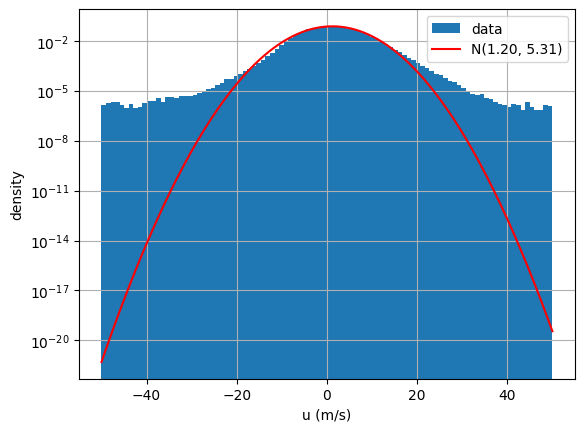

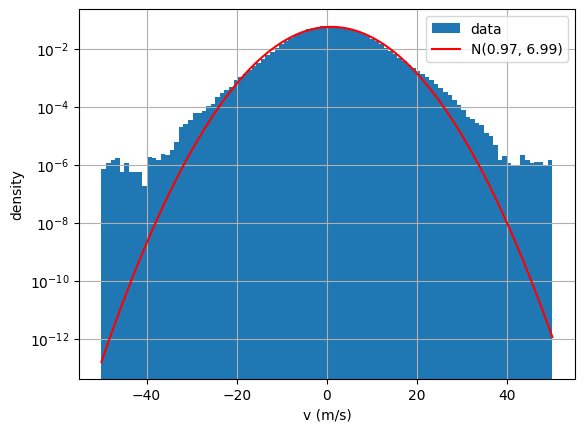

In [261]:
from scipy.stats import gamma, chi, laplace, norm, dgamma

yscale = 'log'

vmax = 50
nbins = 100

bins = np.linspace(-vmax, vmax, nbins)

n = 500000
subsample = df['u'].dropna().sample(n)
loc_u, scale_u = norm.fit(subsample)
shape_dg_u, loc_dg_u, scale_dg_u = dgamma.fit(subsample)

subsample = df['v'].dropna().sample(n)
loc_v, scale_v = norm.fit(subsample)

x = np.linspace(-vmax, vmax, 2*nbins)
pdf_u = norm.pdf(x, loc_u, scale_u)
pdf_dg_u = dgamma.pdf(x, shape_dg_u, loc_dg_u, scale_dg_u)
pdf_v = norm.pdf(x, loc_v, scale_v)

df['u'].hist(bins=bins, label='data', density=True)
plt.plot(x, pdf_u, 'r-', label=f"N({loc_u:.2f}, {scale_u:.2f})")
#plt.plot(x, pdf_dg_u, 'r-', label=f"DG({shape_dg_u:.2f}, {loc_dg_u:.2f}, {scale_dg_u:.2f})")
plt.yscale(yscale)
plt.xlabel('u (m/s)')
plt.ylabel('density')
plt.legend()
plt.show()

df['v'].hist(bins=bins, label='data', density=True)
plt.plot(x, pdf_v, 'r-', label=f"N({loc_v:.2f}, {scale_v:.2f})")
plt.yscale(yscale)
plt.xlabel('v (m/s)')
plt.ylabel('density')
plt.legend()
plt.show()

/var/folders/hm/p_gkggm17tv72_cpnhrcsjd80000gn/T/ipykernel_29027/3963756188.py:48: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(X, Y, density.T, levels=10, cmap='Reds', norm=norm)


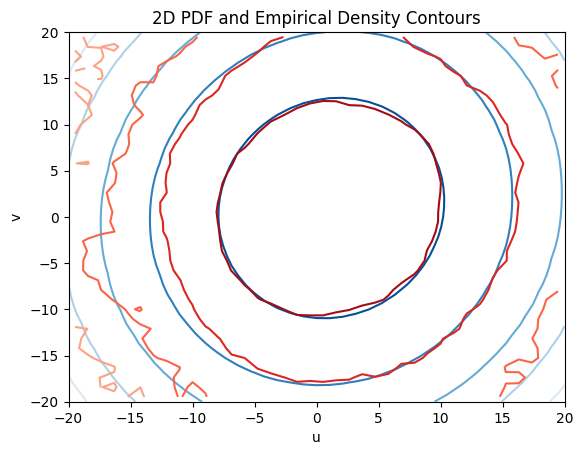

In [272]:
from scipy.stats import multivariate_normal
import seaborn as sns
from matplotlib.colors import Normalize, LogNorm
from scipy.ndimage import gaussian_filter

vmax = 20

n = 500000
sample = df[['u', 'v']].dropna()
subsample = sample.sample(n)
mean = subsample.mean()
cov = subsample.cov()

# Create a multivariate normal distribution with the fitted parameters
mvn = multivariate_normal(mean=mean, cov=cov)

# Create a grid of points
nbins = 40
x = np.linspace(-vmax, vmax, nbins-1)
y = np.linspace(-vmax, vmax, nbins-1)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Calculate the PDF values for the grid
Z = mvn.pdf(pos)
#Z /= Z.sum()

# Plot the contours of the empirical density
#plt.hexbin(subsample['u'], subsample['v'], gridsize=50, cmap='Reds', alpha=0.6, norm=LogNorm())
levels = 10

bins = np.linspace(-vmax, vmax, nbins-1)

density, x_edges, y_edges = np.histogram2d(sample['u'], sample['v'], bins=bins, density=True)
#density = gaussian_filter(density, sigma=2)
#density += 1e-14  # Avoid division by zero
#density /= density.sum()

#norm = Normalize(vmin=density.min(), vmax=density.max())
norm = LogNorm(vmin=Z.min(), vmax=Z.max())

# Plot the 2D PDF
plt.contour(X, Y, Z, levels=levels, norm=norm, cmap='Blues')

# Generate meshgrid for plotting
centers = (bins[:-1] + bins[1:])/2
X, Y = np.meshgrid(centers, centers)
plt.contour(X, Y, density.T, levels=10, cmap='Reds', norm=norm)

plt.xlim([-vmax, vmax])
plt.ylim([-vmax, vmax])


plt.xlabel('u')
plt.ylabel('v')
plt.title('2D PDF and Empirical Density Contours')
plt.show()


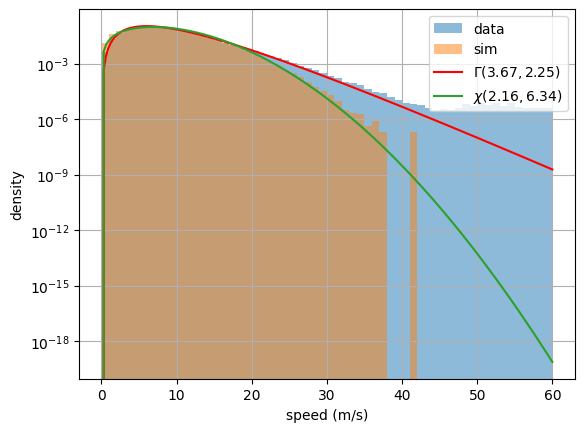

In [ ]:
yscale = 'log'

vmax = 60
nbins = vmax+1
n = 500000

speed = df['speed']
speed = np.linalg.norm(df[['u', 'v']], axis=1)

subsample = speed.dropna().sample(n)
subsample = subsample[subsample > 0]
shape, loc, scale = gamma.fit(subsample, floc=0)
df_chi, loc_chi, scale_chi = chi.fit(subsample)

# create an artifical sample
m = int(5e6)
sim_vels = mvn.rvs(size=m)  # fitted in previous cell
sim_speeds = np.linalg.norm(sim_vels, axis=1)


bins = np.linspace(0, vmax, nbins)
speed.hist(bins=bins, density=True, label="data", alpha=0.5)
plt.hist(sim_speeds, bins=bins, density=True, label="sim", alpha=0.5)
x = np.linspace(0, vmax, 200)
pdf_gamma = gamma.pdf(x, shape, loc, scale)
pdf_chi = chi.pdf(x, df_chi, loc_chi, scale_chi)
plt.plot(x, pdf_gamma, 'r-', label=f"$\\Gamma({shape:.2f}, {scale:.2f})$")
plt.plot(x, pdf_chi, '-', label=f"$\\chi({df_chi:.2f}, {scale_chi:.2f})$")
plt.xlabel('speed (m/s)')
plt.ylabel('density')
plt.yscale(yscale)
plt.legend()
plt.show()

In [277]:
limit = 75
#field = 'u'
#x = df[field]
x = df['speed']

(len(x)-np.sum(x.abs()<=limit))/len(x) * 100

0.003283047369337047

In 2021, 0.0033% of scans had vertically integrated speed greater than 75 m/s.

In [275]:
# Investigate outliers

# KDTX    |2011-05-04
# KLRX    |2006-10-12

station = "KDTX"
year = 2011


def check_station_year(station, year):
    print(f"{station} {year}")
    filename = f"{root}/scans/{year}/{station}-{year}.csv"
    dd = pd.read_csv(filename, parse_dates=['datetime'])
    display(dd['speed'].sort_values(ascending=False).head(10))

check_station_year("KDTX", 2011)
check_station_year("KLRX", 2006)



KDTX 2011


21514    4.485016e+06
6523     7.406100e+01
66688    5.857080e+01
1599     5.801740e+01
13696    5.781850e+01
6524     5.628500e+01
8598     5.196240e+01
8590     5.046150e+01
8610     5.013120e+01
8614     4.981810e+01
Name: speed, dtype: float64

KLRX 2006


57580    1.055385e+09
62644    8.911950e+01
66601    6.990740e+01
65005    6.899240e+01
17273    6.653970e+01
66687    6.042820e+01
64996    5.927690e+01
62676    5.849240e+01
59847    5.713520e+01
71156    5.586990e+01
Name: speed, dtype: float64